# Popular Audio Features Analysis

- Student name: Myrna Grace Calip
- Student pace: Part-Time
- Scheduled project review date/time: 1/6/21
- Instructor name: Claude Fried
- Blog post URL:


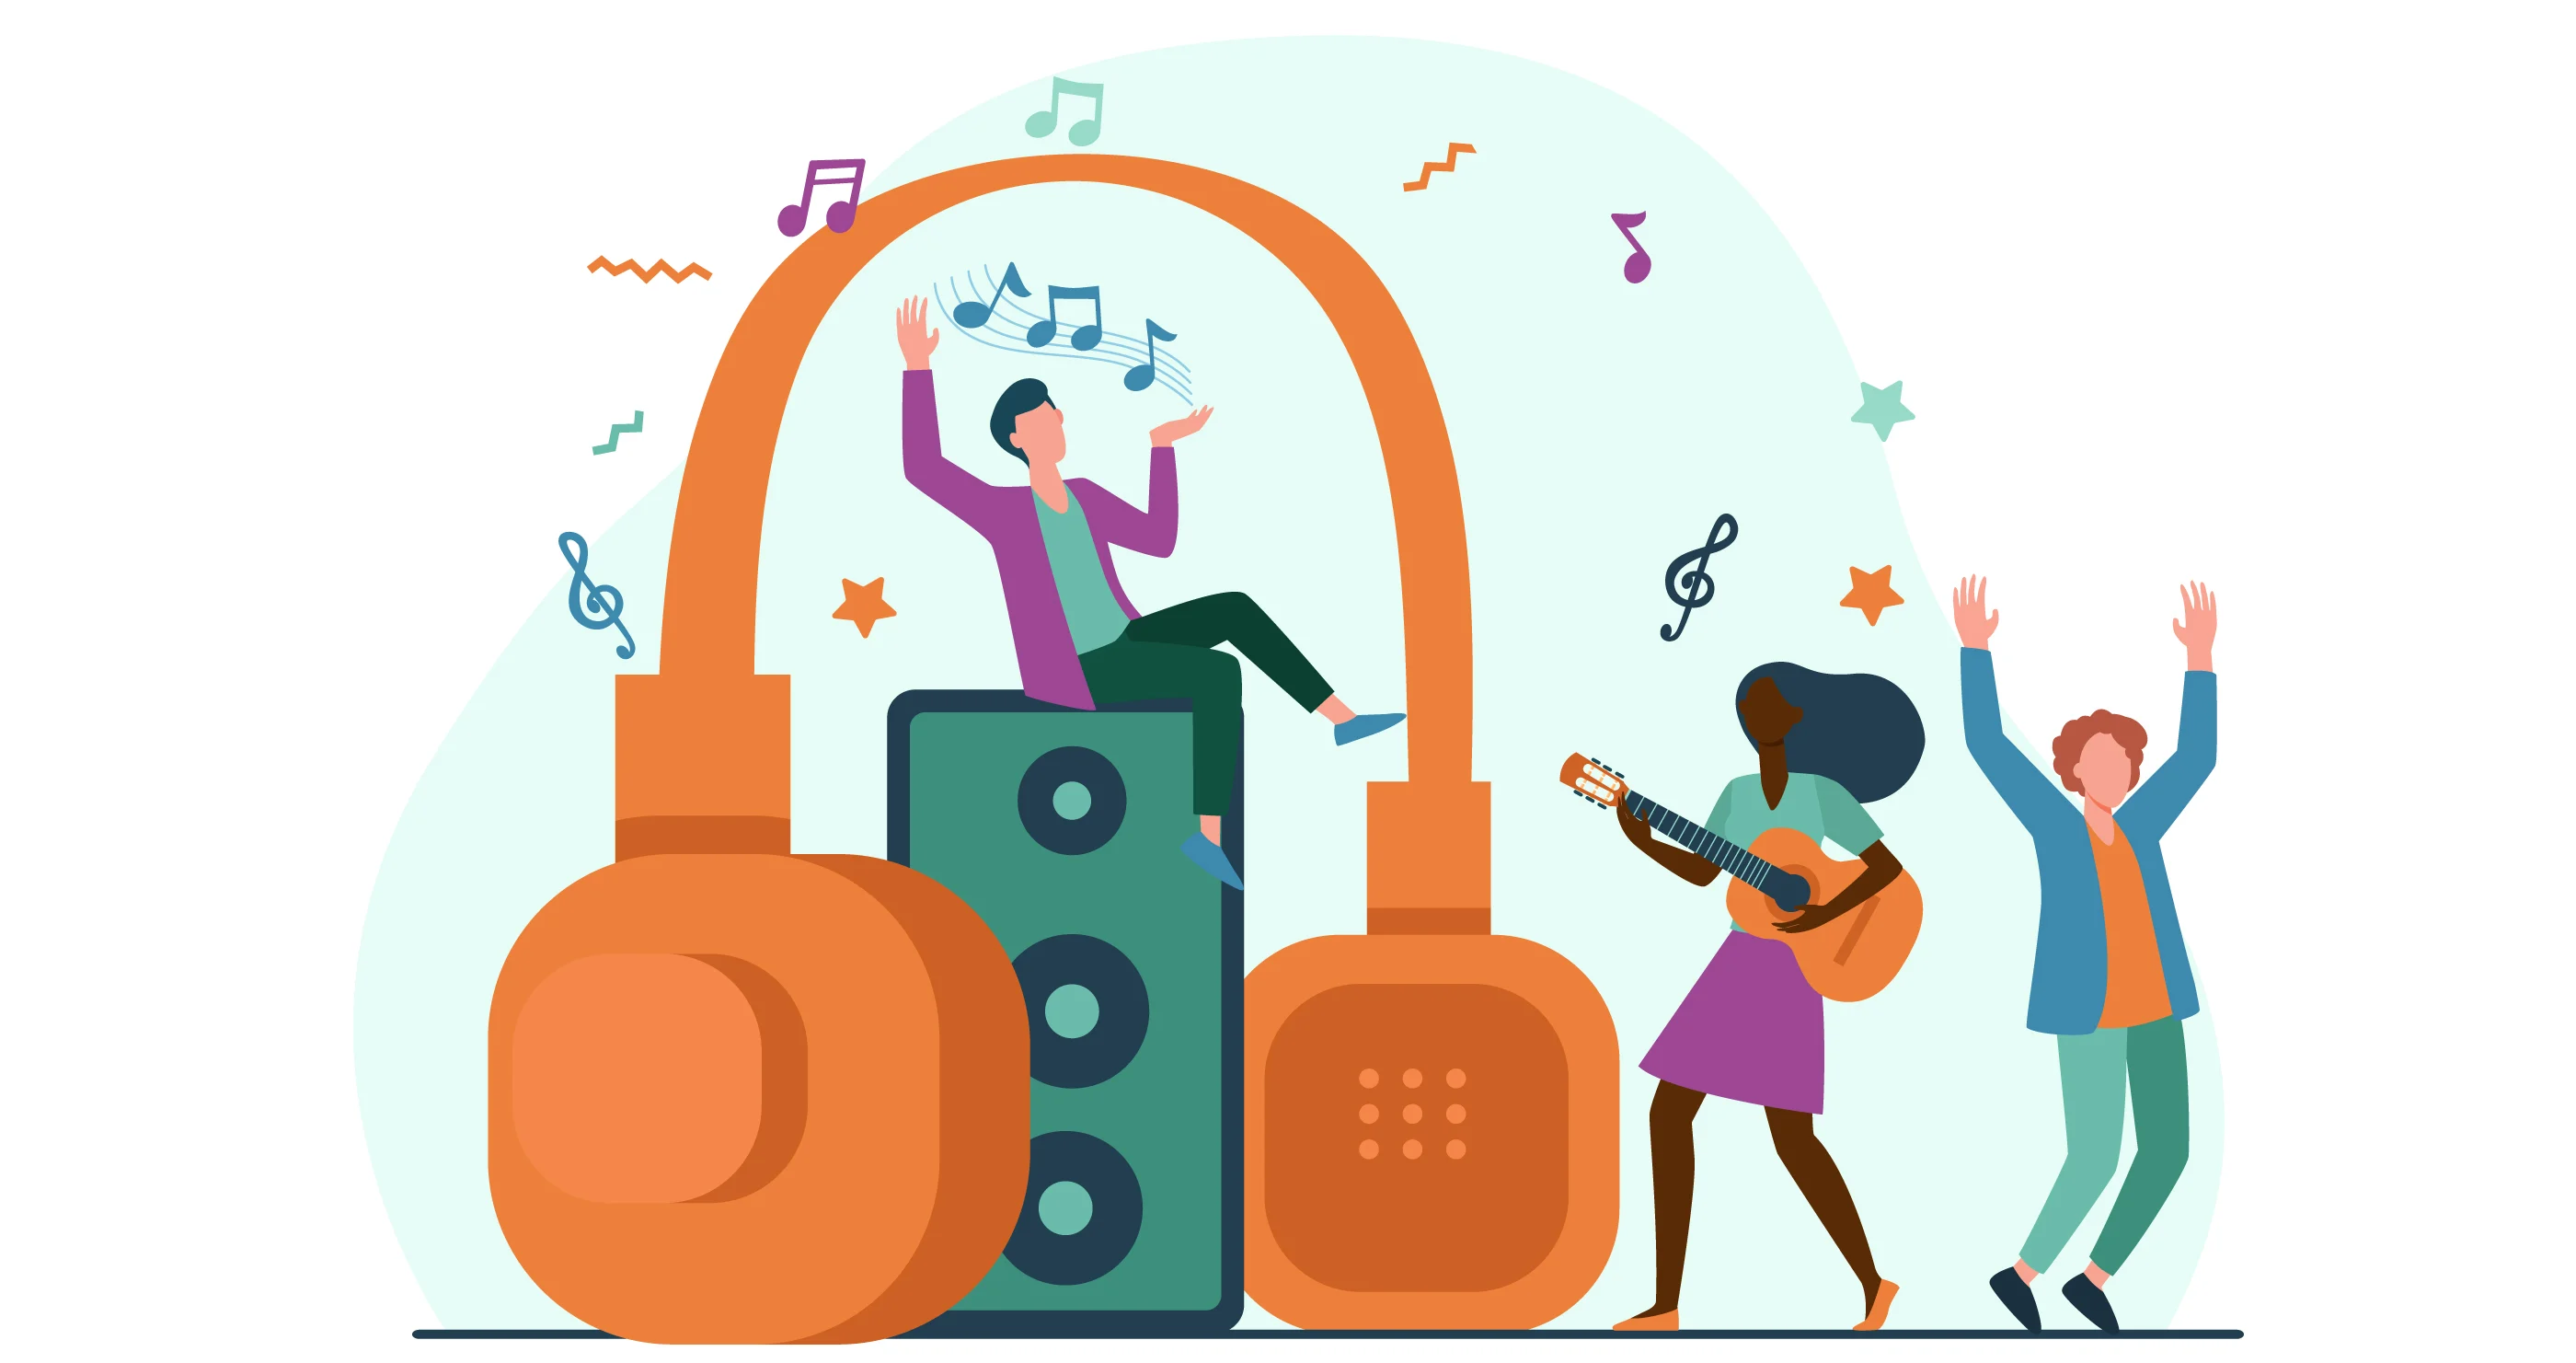

# Business Problem

Popular music streaming platforms such as Youtube, Spotify, and SoundCloud has made it easier for musicians of all types to upload music content and share it instantly with audiences world wide. Yet, as a musician it is hard to get your music heard let alone become a top hit. Our analysis offers record labels, artists, and producers determine what qualities they should consider when releasing music on streaming platforms based on Spotify's audio features provided from the given [Data](https://www.kaggle.com/vicsuperman/prediction-of-music-genre). 

Our goal is to answer the following questions:

* Which audio features makes an impact on a song's popularity?
* What genre should a record label prioritize when finding an artist?
* Does music theory features contribute to their popularity?


In [132]:
# import libraries

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import datetime
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (VotingClassifier, 
                              RandomForestClassifier, 
                              AdaBoostClassifier, 
                              GradientBoostingClassifier, 
                              AdaBoostClassifier,
                              BaggingClassifier
                             )
from imblearn.pipeline import Pipeline as imbPipeline
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score, cross_validate
from imblearn.over_sampling import SMOTENC
from imblearn.under_sampling import ClusterCentroids
from sklearn.metrics import (accuracy_score, 
                             f1_score, 
                             recall_score, 
                             precision_score,
                             precision_recall_curve,
                             make_scorer,
                             confusion_matrix,
                             plot_confusion_matrix,
                             plot_roc_curve,
                             classification_report,
                             roc_curve,
                             auc,
                             plot_precision_recall_curve,
                             roc_auc_score,
                             log_loss
                             
)
# For plotting the tree.
from sklearn.tree import export_graphviz, plot_tree
from pydotplus import graph_from_dot_data
from IPython.display import Image
from sklearn import tree

import warnings
warnings.filterwarnings('ignore')

import joblib
import xgboost as xgb
from xgboost import plot_importance

# Helper Functions

In [2]:
def get_value_counts(data):
    for count in data.columns:
        print(count)
        print(data[count].value_counts())
        print('                                                  ')
    return count

def unique_values(data):
    for col in data.columns:
        print(col)
        print(data[col].unique())
        print('                                                   ')

def convert_dtype(data,dtype):
    data = data.astype(dtype)
    return data

def make_plot_count(col, data, order = None):
    sns.countplot(x = col, data = data, palette = 'icefire_r', order = order)
    plt.title(f'Frequency in {col}')
    plt.show()
    
def test_train_split(data, TARGET, random_state = 100):
    
    data = data.copy()
    
    # Separate independant variables from dependant variable.
    X = data.drop(columns=[TARGET], axis = 1)
    y = data[TARGET]
    
    X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=random_state)
    
    X_train.reset_index(drop=True, inplace=True)
    X_test.reset_index(drop=True, inplace=True)
    y_train.reset_index(drop=True, inplace=True)
    y_test.reset_index(drop=True, inplace=True)
    
    return X_train, X_test, y_train, y_test
    

# Data Understanding

In [3]:
# Importing the dataframe
# Checking the amount of columns & rows

df = pd.read_csv("data/music_genre.csv")
df.shape

(50005, 18)

In [4]:
# Checking the datatypes & column names
# 5 rows have missing information

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50005 entries, 0 to 50004
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   instance_id       50000 non-null  float64
 1   artist_name       50000 non-null  object 
 2   track_name        50000 non-null  object 
 3   popularity        50000 non-null  float64
 4   acousticness      50000 non-null  float64
 5   danceability      50000 non-null  float64
 6   duration_ms       50000 non-null  float64
 7   energy            50000 non-null  float64
 8   instrumentalness  50000 non-null  float64
 9   key               50000 non-null  object 
 10  liveness          50000 non-null  float64
 11  loudness          50000 non-null  float64
 12  mode              50000 non-null  object 
 13  speechiness       50000 non-null  float64
 14  tempo             50000 non-null  object 
 15  obtained_date     50000 non-null  object 
 16  valence           50000 non-null  float6

## Spotify's Audio Features

Below are the meaning behind Spotify's Audio Features based on their Web API audio features reference.

* **popularity**: The popularity of the track. The value will be between 0 and 100, with 100 being the most popular. The popularity of a track is a value between 0 and 100, with 100 being the most popular. The popularity is calculated by algorithm and is based, in the most part, on the total number of plays the track has had and how recent those plays are. Generally speaking, songs that are being played a lot now will have a higher popularity than songs that were played a lot in the past. Duplicate tracks (e.g. the same track from a single and an album) are rated independently. Artist and album popularity is derived mathematically from track popularity.

* **acousticness**: A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic.

* **danceability**: Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable.

* **duration_ms**: The duration of the track in milliseconds.

* **instrumentalness**: Predicts whether a track contains no vocals. "Ooh" and "aah" sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly "vocal". The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0.

* **key**: The key the track is in. Integers map to pitches using standard Pitch Class notation. E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on. If no key was detected, the value is -1.

* **liveness**: Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live.

* **loudness**: The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typically range between -60 and 0 db.

* **mode**: Mode indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0.

* **speechiness**: Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks.

* **tempo**: The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration.

* **valence**: A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).

* **music_genre**: .




In [5]:
df

,instance_id,artist_name,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
0,32894.0,Röyksopp,Röyksopp's Night Out,27.0,0.00468,0.652,-1.0,0.941,0.79200,A#,0.115,-5.201,Minor,0.0748,100.889,4-Apr,0.759,Electronic
1,46652.0,Thievery Corporation,The Shining Path,31.0,0.01270,0.622,218293.0,0.890,0.95000,D,0.124,-7.043,Minor,0.0300,115.00200000000001,4-Apr,0.531,Electronic
2,30097.0,Dillon Francis,Hurricane,28.0,0.00306,0.620,215613.0,0.755,0.01180,G#,0.534,-4.617,Major,0.0345,127.994,4-Apr,0.333,Electronic
3,62177.0,Dubloadz,Nitro,34.0,0.02540,0.774,166875.0,0.700,0.00253,C#,0.157,-4.498,Major,0.2390,128.014,4-Apr,0.270,Electronic
4,24907.0,What So Not,Divide & Conquer,32.0,0.00465,0.638,222369.0,0.587,0.90900,F#,0.157,-6.266,Major,0.0413,145.036,4-Apr,0.323,Electronic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50000,58878.0,BEXEY,GO GETTA,59.0,0.03340,0.913,-1.0,0.574,0.00000,C#,0.119,-7.022,Major,0.2980,98.02799999999999,4-Apr,0.330,Hip-Hop
50001,43557.0,Roy Woods,Drama (feat. Drake),72.0,0.15700,0.709,251860.0,0.362,0.00000,B,0.109,-9.814,Major,0.0550,122.04299999999999,4-Apr,0.113,Hip-Hop
50002,39767.0,Berner,Lovin' Me (feat. Smiggz),51.0,0.00597,0.693,189483.0,0.763,0.00000,D,0.143,-5.443,Major,0.1460,131.079,4-Apr,0.395,Hip-Hop
50003,57944.0,The-Dream,Shawty Is Da Shit,65.0,0.08310,0.782,262773.0,0.472,0.00000,G,0.106,-5.016,Minor,0.0441,75.88600000000001,4-Apr,0.354,Hip-Hop


In [6]:
# check the stats for the dataset

df.describe()

,instance_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,valence
count,50000.000000,50000.000000,50000.000000,50000.000000,5.000000e+04,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,55888.396360,44.220420,0.306383,0.558241,2.212526e+05,0.599755,0.181601,0.193896,-9.133761,0.093586,0.456264
std,20725.256253,15.542008,0.341340,0.178632,1.286720e+05,0.264559,0.325409,0.161637,6.162990,0.101373,0.247119
min,20002.000000,0.000000,0.000000,0.059600,-1.000000e+00,0.000792,0.000000,0.009670,-47.046000,0.022300,0.000000
25%,37973.500000,34.000000,0.020000,0.442000,1.748000e+05,0.433000,0.000000,0.096900,-10.860000,0.036100,0.257000
50%,55913.500000,45.000000,0.144000,0.568000,2.192810e+05,0.643000,0.000158,0.126000,-7.276500,0.048900,0.448000
75%,73863.250000,56.000000,0.552000,0.687000,2.686122e+05,0.815000,0.155000,0.244000,-5.173000,0.098525,0.648000
max,91759.000000,99.000000,0.996000,0.986000,4.830606e+06,0.999000,0.996000,1.000000,3.744000,0.942000,0.992000


In [7]:
# look at all the columns value counts
# 2489 entries with an empty_field as a artist name
# 2980 entiries with '?' for tempo
get_value_counts(df)

instance_id
69127.0    1
54606.0    1
77158.0    1
28359.0    1
90011.0    1
          ..
67931.0    1
47596.0    1
70990.0    1
33535.0    1
53248.0    1
Name: instance_id, Length: 50000, dtype: int64
                                                  
artist_name
empty_field                2489
Nobuo Uematsu               429
Wolfgang Amadeus Mozart     402
Ludwig van Beethoven        317
Johann Sebastian Bach       314
                           ... 
Black Diamond Heavies         1
Steeve Laffont                1
Fat Pat                       1
Cult To Follow                1
Bryan Ferry                   1
Name: artist_name, Length: 6863, dtype: int64
                                                  
track_name
Home                                                                           16
Forever                                                                        15
Without You                                                                    14
Wake Up                      

'music_genre'

## Data Preparation

Before runnning our models, we preprocess our data to see if there is any necessary data cleaning and feature engineering needed to be processed.

In [8]:
# get the unique values from each column

unique_values(df)

instance_id
[32894. 46652. 30097. ... 39767. 57944. 63470.]
                                                   
artist_name
['Röyksopp' 'Thievery Corporation' 'Dillon Francis' ... 'Darshan Raval'
 'Powers Pleasant' 'Millonario']
                                                   
track_name
["Röyksopp's Night Out" 'The Shining Path' 'Hurricane' ...
 'Drama (feat. Drake)' "Lovin' Me (feat. Smiggz)" 'Hip Hop Hooray']
                                                   
popularity
[27. 31. 28. 34. 32. 47. 46. 43. 39. 22. 30. 50. 59. 29. 35. 44. 33. 56.
 21. 48. 45. 53. 63. 25. 36. 37. 51. 55. 49. 41. 38. 52. 24. 42. 26. 96.
 40. 23. 61. 54. 66. 70. 67. 60. 58. 65. 69. 72. 64. 62. 57.  0. 76. 20.
 74. 71. 84. 68. 18. 82.  3. 11. 17. 15. 12. 10. 13. 16. 14.  9. 19.  8.
  7.  4.  2.  1.  5.  6. nan 79. 73. 75. 78. 83. 81. 80. 77. 85. 97. 88.
 87. 86. 99. 89. 93. 90. 94. 91. 95. 92.]
                                                   
acousticness
[4.68e-03 1.27e-02 3.06e-03 ... 8.79e-04 5.20e

In [9]:
# Check the number of duplicates in this dataset
df.duplicated().value_counts()

False    50001
True         4
dtype: int64

In [10]:
# looks like the duplicates are mostly missing values
df[df.duplicated()]

,instance_id,artist_name,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
10001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
# drop all the rows that have missing information
df.dropna(axis=0, inplace= True)

In [12]:
# sanity check on duplicates and missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 50004
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   instance_id       50000 non-null  float64
 1   artist_name       50000 non-null  object 
 2   track_name        50000 non-null  object 
 3   popularity        50000 non-null  float64
 4   acousticness      50000 non-null  float64
 5   danceability      50000 non-null  float64
 6   duration_ms       50000 non-null  float64
 7   energy            50000 non-null  float64
 8   instrumentalness  50000 non-null  float64
 9   key               50000 non-null  object 
 10  liveness          50000 non-null  float64
 11  loudness          50000 non-null  float64
 12  mode              50000 non-null  object 
 13  speechiness       50000 non-null  float64
 14  tempo             50000 non-null  object 
 15  obtained_date     50000 non-null  object 
 16  valence           50000 non-null  float6

In [13]:
df.isna().sum()

instance_id         0
artist_name         0
track_name          0
popularity          0
acousticness        0
danceability        0
duration_ms         0
energy              0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
speechiness         0
tempo               0
obtained_date       0
valence             0
music_genre         0
dtype: int64

### Popularity

* Convert dtype from float to int
* Set popular song to the value 1 and nonpopular song to 0

In [14]:
# get popularity frequency
most_popular = df.sort_values('popularity', ascending = False)
most_popular.head(10)

,instance_id,artist_name,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
26239,84744.0,Post Malone,Wow.,99.0,0.16300,0.833,149520.0,0.539,0.000002,B,0.1010,-7.399,Minor,0.1780,99.947,4-Apr,0.385,Rap
25194,59859.0,Post Malone,Sunflower - Spider-Man: Into the Spider-Verse,97.0,0.55600,0.760,158040.0,0.479,0.000000,D,0.0703,-5.574,Major,0.0466,89.911,4-Apr,0.913,Rap
47024,89355.0,J. Cole,MIDDLE CHILD,96.0,0.14900,0.837,213594.0,0.364,0.000000,G#,0.2710,-11.713,Major,0.2760,123.984,4-Apr,0.463,Hip-Hop
105,49721.0,DJ Snake,"Taki Taki (with Selena Gomez, Ozuna & Cardi B)",96.0,0.15300,0.841,212500.0,0.798,0.000003,C#,0.0618,-4.206,Minor,0.2290,95.948,4-Apr,0.591,Electronic
47596,86123.0,Paulo Londra,Adan y Eva,95.0,0.32300,0.767,258639.0,0.709,0.000000,C#,0.0676,-4.470,Major,0.3360,?,4-Apr,0.720,Hip-Hop
48249,27221.0,Meek Mill,Going Bad (feat. Drake),95.0,0.25900,0.889,180522.0,0.496,0.000000,E,0.2520,-6.365,Minor,0.0905,86.00299999999999,4-Apr,0.544,Hip-Hop
28537,59982.0,Travis Scott,SICKO MODE,94.0,0.00513,0.834,312820.0,0.730,0.000000,G#,0.1240,-3.714,Major,0.2220,155.00799999999998,4-Apr,0.446,Rap
28055,25783.0,Post Malone,Better Now,93.0,0.35400,0.680,231267.0,0.563,0.000000,A#,0.1360,-5.843,Major,0.0454,145.028,4-Apr,0.374,Rap
29974,35484.0,21 Savage,a lot,93.0,0.03950,0.837,288624.0,0.636,0.001250,C#,0.3420,-7.643,Major,0.0860,145.972,4-Apr,0.274,Rap
48850,28227.0,XXXTENTACION,SAD!,92.0,0.25800,0.740,166606.0,0.613,0.003720,G#,0.1230,-4.880,Major,0.1450,75.023,4-Apr,0.473,Hip-Hop


The above shows the dataset's top ten most popular songs. 

In [15]:
# convert to integer
df['popularity'] = convert_dtype(df['popularity'],'int64')

In [16]:
# set all the rows that have a popularity > 50 : 1, popularity < 50 : 0

df['popular_song'] = df['popularity'].map(lambda x: 1 if x >= 50 else 0)

### Tempos

* Exploring the missing tempos
* Converting dtype to float

In [17]:
# Find all the tempos that have a question mark
df[df['tempo'] == '?']

,instance_id,artist_name,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre,popular_song
5,89064.0,Axel Boman,Hello,47,0.00523,0.755,519468.0,0.731,0.854000,D,0.2160,-10.517,Minor,0.0412,?,4-Apr,0.6140,Electronic,0
32,25836.0,PEEKABOO,Arrival,45,0.02330,0.729,274286.0,0.869,0.585000,F,0.0944,-7.569,Minor,0.1290,?,4-Apr,0.1380,Electronic,0
35,27048.0,Fabian Mazur,If U Wanted To,33,0.10800,0.493,-1.0,0.682,0.000000,A,0.1960,-5.781,Minor,0.2870,?,4-Apr,0.2390,Electronic,0
36,55617.0,Wax Tailor,The Games You Play,45,0.04780,0.646,253333.0,0.649,0.002520,G,0.3530,-5.259,Major,0.1170,?,4-Apr,0.7270,Electronic,0
39,69685.0,Dahu,Vessel,37,0.20300,0.769,429941.0,0.551,0.882000,A#,0.1090,-12.520,Minor,0.0408,?,4-Apr,0.0618,Electronic,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49918,63058.0,Big Sean,Bigger Than Me,58,0.29600,0.379,292520.0,0.644,0.000000,A#,0.3130,-7.933,Minor,0.1120,?,5-Apr,0.1440,Hip-Hop,1
49964,53387.0,Millonario,Rayas de Patrón,59,0.08470,0.929,215200.0,0.737,0.000000,G#,0.8610,-6.424,Major,0.1020,?,4-Apr,0.8860,Hip-Hop,1
49967,76585.0,MadeinTYO,I Want (feat. 2 Chainz),62,0.17900,0.860,233293.0,0.625,0.000136,D,0.3000,-6.922,Major,0.1050,?,4-Apr,0.2210,Hip-Hop,1
49976,79654.0,Big Sean,Sunday Morning Jetpack,52,0.70000,0.462,225067.0,0.741,0.000000,A#,0.3400,-8.008,Minor,0.1620,?,4-Apr,0.5890,Hip-Hop,1


In [18]:
# 4980 entries that have missing tempo info, that's a lot since it is an important feature
missing_tempo = df[df['tempo'] == '?']
missing_tempo

,instance_id,artist_name,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre,popular_song
5,89064.0,Axel Boman,Hello,47,0.00523,0.755,519468.0,0.731,0.854000,D,0.2160,-10.517,Minor,0.0412,?,4-Apr,0.6140,Electronic,0
32,25836.0,PEEKABOO,Arrival,45,0.02330,0.729,274286.0,0.869,0.585000,F,0.0944,-7.569,Minor,0.1290,?,4-Apr,0.1380,Electronic,0
35,27048.0,Fabian Mazur,If U Wanted To,33,0.10800,0.493,-1.0,0.682,0.000000,A,0.1960,-5.781,Minor,0.2870,?,4-Apr,0.2390,Electronic,0
36,55617.0,Wax Tailor,The Games You Play,45,0.04780,0.646,253333.0,0.649,0.002520,G,0.3530,-5.259,Major,0.1170,?,4-Apr,0.7270,Electronic,0
39,69685.0,Dahu,Vessel,37,0.20300,0.769,429941.0,0.551,0.882000,A#,0.1090,-12.520,Minor,0.0408,?,4-Apr,0.0618,Electronic,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49918,63058.0,Big Sean,Bigger Than Me,58,0.29600,0.379,292520.0,0.644,0.000000,A#,0.3130,-7.933,Minor,0.1120,?,5-Apr,0.1440,Hip-Hop,1
49964,53387.0,Millonario,Rayas de Patrón,59,0.08470,0.929,215200.0,0.737,0.000000,G#,0.8610,-6.424,Major,0.1020,?,4-Apr,0.8860,Hip-Hop,1
49967,76585.0,MadeinTYO,I Want (feat. 2 Chainz),62,0.17900,0.860,233293.0,0.625,0.000136,D,0.3000,-6.922,Major,0.1050,?,4-Apr,0.2210,Hip-Hop,1
49976,79654.0,Big Sean,Sunday Morning Jetpack,52,0.70000,0.462,225067.0,0.741,0.000000,A#,0.3400,-8.008,Minor,0.1620,?,4-Apr,0.5890,Hip-Hop,1


In [19]:
get_value_counts(missing_tempo)

instance_id
30215.0    1
76066.0    1
74069.0    1
75112.0    1
74052.0    1
          ..
69294.0    1
20092.0    1
88920.0    1
83631.0    1
51200.0    1
Name: instance_id, Length: 4980, dtype: int64
                                                  
artist_name
empty_field                260
Nobuo Uematsu               42
Wolfgang Amadeus Mozart     37
Ludwig van Beethoven        30
Frédéric Chopin             29
                          ... 
GZA                          1
The Driver Era               1
2 LIVE CREW                  1
David Monrad Johansen        1
The Roots                    1
Name: artist_name, Length: 2368, dtype: int64
                                                  
track_name
Paradise                          3
The Light                         3
Rudolph The Red-Nosed Reindeer    3
Smile                             3
Closer                            3
                                 ..
Soul Survivor                     1
Yellow Calx                       1

'popular_song'

In [20]:
missing_tempo['track_name'].value_counts().head(100)

Paradise                          3
The Light                         3
Rudolph The Red-Nosed Reindeer    3
Smile                             3
Closer                            3
                                 ..
You Lie                           2
Good Times                        2
Runaway                           2
King                              2
Pull Up                           2
Name: track_name, Length: 100, dtype: int64

In [21]:
missing_tempo.sort_values('popularity', ascending = False).head(100)

,instance_id,artist_name,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre,popular_song
47596,86123.0,Paulo Londra,Adan y Eva,95,0.32300,0.767,258639.0,0.709,0.000000,C#,0.0676,-4.470,Major,0.3360,?,4-Apr,0.7200,Hip-Hop,1
35822,88617.0,Imagine Dragons,Believer,89,0.06220,0.776,204347.0,0.780,0.000000,A#,0.0810,-4.374,Minor,0.1280,?,4-Apr,0.6660,Rock,1
26495,28877.0,Logic,Keanu Reeves,87,0.05910,0.710,225987.0,0.888,0.000000,D,0.1340,-6.457,Major,0.2350,?,4-Apr,0.8160,Rap,1
49259,43309.0,Metro Boomin,Space Cadet (feat. Gunna),87,0.36800,0.901,203267.0,0.464,0.000017,F,0.2380,-9.789,Minor,0.0645,?,4-Apr,0.6380,Hip-Hop,1
49213,58295.0,Future,Fine China,85,0.04840,0.656,141587.0,0.542,0.000000,G,0.1260,-7.358,Major,0.3230,?,4-Apr,0.5510,Hip-Hop,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29161,20944.0,Eminem,Stepping Stone,73,0.03050,0.616,309638.0,0.684,0.000000,G,0.3760,-6.032,Major,0.3110,?,4-Apr,0.3120,Rap,1
46902,78161.0,Drake,Emotionless,73,0.02490,0.413,-1.0,0.677,0.000000,C#,0.0793,-5.120,Major,0.2550,?,4-Apr,0.0845,Hip-Hop,1
45733,42893.0,Offset,On Fleek (feat. Quavo),73,0.24300,0.872,229587.0,0.472,0.000002,A,0.0902,-8.217,Major,0.2050,?,4-Apr,0.2550,Hip-Hop,1
28227,76704.0,Drake,Elevate,73,0.01500,0.758,184960.0,0.474,0.000000,C#,0.1160,-8.720,Major,0.1460,?,4-Apr,0.0541,Rap,1


In [133]:
missing_tempo['popular_song'] = missing_tempo['popularity'].map(lambda x: 1 if x >= 50 else 0)

In [23]:
missing_tempo

,instance_id,artist_name,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre,popular_song
5,89064.0,Axel Boman,Hello,47,0.00523,0.755,519468.0,0.731,0.854000,D,0.2160,-10.517,Minor,0.0412,?,4-Apr,0.6140,Electronic,0
32,25836.0,PEEKABOO,Arrival,45,0.02330,0.729,274286.0,0.869,0.585000,F,0.0944,-7.569,Minor,0.1290,?,4-Apr,0.1380,Electronic,0
35,27048.0,Fabian Mazur,If U Wanted To,33,0.10800,0.493,-1.0,0.682,0.000000,A,0.1960,-5.781,Minor,0.2870,?,4-Apr,0.2390,Electronic,0
36,55617.0,Wax Tailor,The Games You Play,45,0.04780,0.646,253333.0,0.649,0.002520,G,0.3530,-5.259,Major,0.1170,?,4-Apr,0.7270,Electronic,0
39,69685.0,Dahu,Vessel,37,0.20300,0.769,429941.0,0.551,0.882000,A#,0.1090,-12.520,Minor,0.0408,?,4-Apr,0.0618,Electronic,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49918,63058.0,Big Sean,Bigger Than Me,58,0.29600,0.379,292520.0,0.644,0.000000,A#,0.3130,-7.933,Minor,0.1120,?,5-Apr,0.1440,Hip-Hop,1
49964,53387.0,Millonario,Rayas de Patrón,59,0.08470,0.929,215200.0,0.737,0.000000,G#,0.8610,-6.424,Major,0.1020,?,4-Apr,0.8860,Hip-Hop,1
49967,76585.0,MadeinTYO,I Want (feat. 2 Chainz),62,0.17900,0.860,233293.0,0.625,0.000136,D,0.3000,-6.922,Major,0.1050,?,4-Apr,0.2210,Hip-Hop,1
49976,79654.0,Big Sean,Sunday Morning Jetpack,52,0.70000,0.462,225067.0,0.741,0.000000,A#,0.3400,-8.008,Minor,0.1620,?,4-Apr,0.5890,Hip-Hop,1


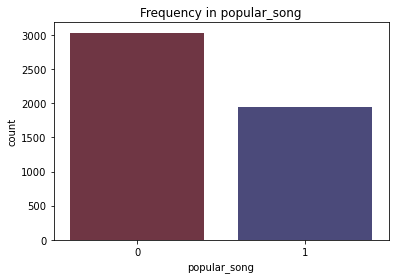

In [24]:
make_plot_count('popular_song',missing_tempo)

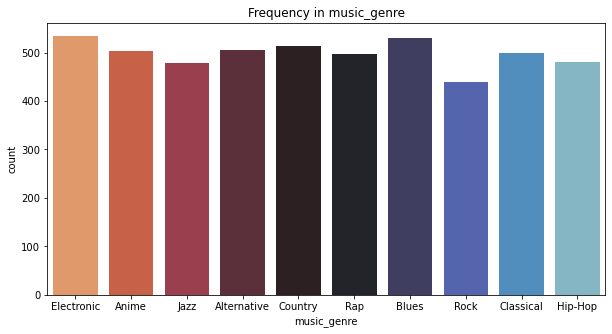

In [25]:
plt.figure(figsize = (10, 5))
make_plot_count('music_genre',missing_tempo)

In [26]:
df.drop(df[df['tempo'] == '?'].index, inplace = True)

In [27]:
df['tempo'] = convert_dtype(df['tempo'],'float')

In [28]:
# round the tempo decimal places to 3 decimal places
df['tempo'] = np.round(df['tempo'], decimals = 3)
df['tempo'].value_counts

<bound method IndexOpsMixin.value_counts of 0        100.889
1        115.002
2        127.994
3        128.014
4        145.036
          ...   
50000     98.028
50001    122.043
50002    131.079
50003     75.886
50004     99.201
Name: tempo, Length: 45020, dtype: float64>

### Duration_ms
* What does it mean to have a track duration of -1.0 millisecond?
* Explore the songs that have a during of -1.0 millisecond

In [29]:
df.duration_ms.value_counts()

-1.0         4460
 240000.0      31
 192000.0      28
 180000.0      26
 185600.0      17
             ... 
 193425.0       1
 189597.0       1
 204056.0       1
 187671.0       1
 171363.0       1
Name: duration_ms, Length: 24280, dtype: int64

In [30]:
negative_one = df[df['duration_ms'] == -1.0]
negative_one

,instance_id,artist_name,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre,popular_song
0,32894.0,Röyksopp,Röyksopp's Night Out,27,0.00468,0.652,-1.0,0.941,0.792000,A#,0.1150,-5.201,Minor,0.0748,100.889,4-Apr,0.7590,Electronic,0
13,62039.0,DJ Shadow,Broken Levee Blues,31,0.86000,0.737,-1.0,0.405,0.036100,A,0.1730,-10.536,Minor,0.0424,154.745,4-Apr,0.6470,Electronic,0
16,83926.0,San Holo,One Thing,59,0.13600,0.336,-1.0,0.746,0.000000,C#,0.7370,-4.315,Minor,0.0685,151.756,4-Apr,0.2100,Electronic,1
24,40033.0,The Prodigy,Diesel Power,56,0.06800,0.725,-1.0,0.877,0.000036,C,0.0900,-3.496,Major,0.0646,105.919,4-Apr,0.0977,Electronic,1
40,50080.0,The Presets,Ghosts,36,0.18100,0.611,-1.0,0.676,0.000005,C#,0.1390,-9.113,Major,0.0461,139.959,4-Apr,0.5730,Electronic,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49956,37037.0,empty_field,What You Like (feat. Ty Dolla $ign & Wiz Khalifa),52,0.13300,0.867,-1.0,0.618,0.000002,B,0.1280,-4.956,Minor,0.0614,140.005,4-Apr,0.8570,Hip-Hop,1
49969,61010.0,Bone Thugs-N-Harmony,No Surrender,47,0.01270,0.706,-1.0,0.787,0.000000,A,0.2650,-5.314,Major,0.0888,85.963,4-Apr,0.2430,Hip-Hop,0
49979,29598.0,Young Dolph,Thinking Out Loud,47,0.48300,0.789,-1.0,0.452,0.000000,B,0.0892,-7.538,Minor,0.4800,140.101,4-Apr,0.2840,Hip-Hop,0
49981,90232.0,Mac Miller,Party On Fifth Ave.,60,0.06350,0.594,-1.0,0.823,0.000000,A,0.0950,-5.210,Major,0.3320,97.101,4-Apr,0.6630,Hip-Hop,1


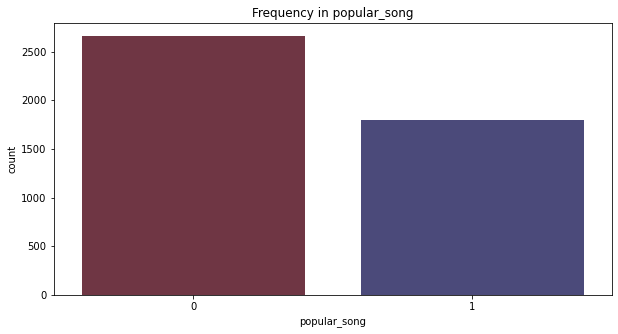

In [31]:
plt.figure(figsize = (10, 5))
make_plot_count('popular_song', negative_one)

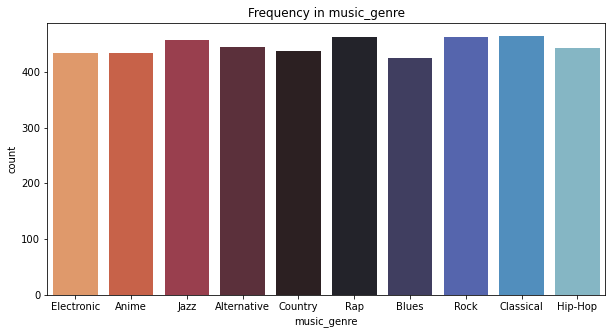

In [32]:
plt.figure(figsize = (10, 5))
make_plot_count('music_genre', negative_one)

For the sake of accuracy in our model we will be dropping the tracks that have a duration of -1.0 since it could negatively impact our model. Based on the Spotify search feature, the correct track duration_ms is provided as well.

In [33]:
df.drop(df[df['duration_ms'] == -1.0].index, inplace = True)
df.shape

(40560, 19)

In [34]:
df['duration_ms'] = convert_dtype(df['duration_ms'],'int64')

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40560 entries, 1 to 50004
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   instance_id       40560 non-null  float64
 1   artist_name       40560 non-null  object 
 2   track_name        40560 non-null  object 
 3   popularity        40560 non-null  int64  
 4   acousticness      40560 non-null  float64
 5   danceability      40560 non-null  float64
 6   duration_ms       40560 non-null  int64  
 7   energy            40560 non-null  float64
 8   instrumentalness  40560 non-null  float64
 9   key               40560 non-null  object 
 10  liveness          40560 non-null  float64
 11  loudness          40560 non-null  float64
 12  mode              40560 non-null  object 
 13  speechiness       40560 non-null  float64
 14  tempo             40560 non-null  float64
 15  obtained_date     40560 non-null  object 
 16  valence           40560 non-null  float6

### Mode

Mode is based on whether the key of the track is major or minor. At a music theory stand point, the difference between the two is that a Major scale has a natural third (whole step) when going up the scale and a Minor scale consists of a minor third (half step) when going up the scale. (Knowledge based on being an orchestra dork during my adolescence)

* Change mode key signature values from 'Major': 1 and 'Minor': 0
* Convert dtype to int

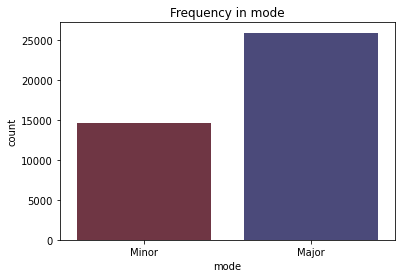

In [36]:
make_plot_count('mode', df)

In [37]:
df['mode'] = df['mode'].map(lambda x: 1 if x == 'Major' else 0)
df

,instance_id,artist_name,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre,popular_song
1,46652.0,Thievery Corporation,The Shining Path,31,0.01270,0.622,218293,0.890,0.950000,D,0.124,-7.043,0,0.0300,115.002,4-Apr,0.531,Electronic,0
2,30097.0,Dillon Francis,Hurricane,28,0.00306,0.620,215613,0.755,0.011800,G#,0.534,-4.617,1,0.0345,127.994,4-Apr,0.333,Electronic,0
3,62177.0,Dubloadz,Nitro,34,0.02540,0.774,166875,0.700,0.002530,C#,0.157,-4.498,1,0.2390,128.014,4-Apr,0.270,Electronic,0
4,24907.0,What So Not,Divide & Conquer,32,0.00465,0.638,222369,0.587,0.909000,F#,0.157,-6.266,1,0.0413,145.036,4-Apr,0.323,Electronic,0
6,43760.0,Jordan Comolli,Clash,46,0.02890,0.572,214408,0.803,0.000008,B,0.106,-4.294,1,0.3510,149.995,4-Apr,0.230,Electronic,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49999,28408.0,Night Lovell,Barbie Doll,56,0.13300,0.849,237667,0.660,0.000008,C,0.296,-7.195,1,0.0516,99.988,4-Apr,0.629,Hip-Hop,1
50001,43557.0,Roy Woods,Drama (feat. Drake),72,0.15700,0.709,251860,0.362,0.000000,B,0.109,-9.814,1,0.0550,122.043,4-Apr,0.113,Hip-Hop,1
50002,39767.0,Berner,Lovin' Me (feat. Smiggz),51,0.00597,0.693,189483,0.763,0.000000,D,0.143,-5.443,1,0.1460,131.079,4-Apr,0.395,Hip-Hop,1
50003,57944.0,The-Dream,Shawty Is Da Shit,65,0.08310,0.782,262773,0.472,0.000000,G,0.106,-5.016,0,0.0441,75.886,4-Apr,0.354,Hip-Hop,1


In [38]:
df.value_counts('mode')

mode
1    25959
0    14601
dtype: int64

In [39]:
df['mode'] = convert_dtype(df['mode'],'int64')

### Data Visualization

### Frequency of Popular Songs

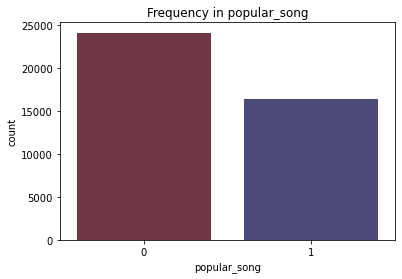

In [42]:
make_plot_count('popular_song',df)

### Frequency of Popular Songs Among Genres

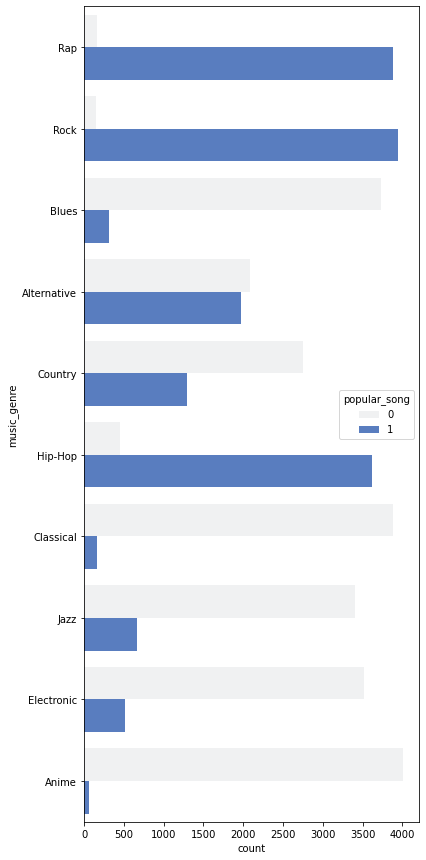

In [43]:
# visualizing the popularity among the music genres

fig, ax = plt.subplots(figsize=(6,15))
# sns.set_color_codes('pastel')
sns.set_color_codes("muted")
ax = sns.countplot(y='music_genre', hue='popular_song', data=df.sort_values('popular_song', ascending=False), color='b')


Our dataset before modeling is showing that music genres rap, hip-hop, and rock are the most popular music genres while Anime, Classical, and Blues are the least popular. 

### Frequency of Popular Songs Among Key Signatures

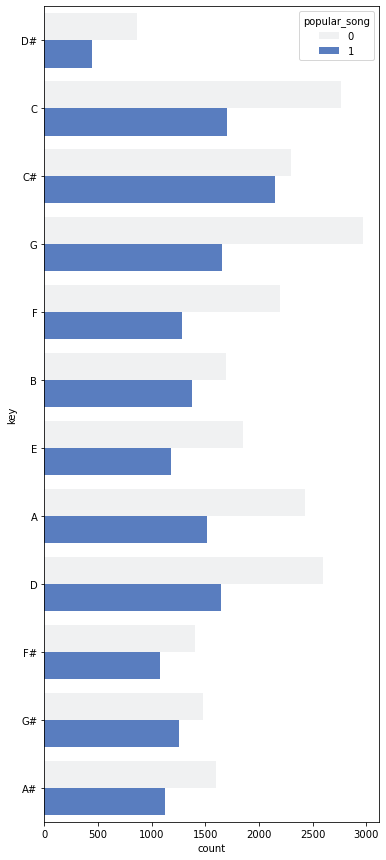

In [44]:
fig, ax = plt.subplots(figsize=(6,15))
# sns.set_color_codes('pastel')
sns.set_color_codes("muted")
ax = sns.countplot(y='key', hue='popular_song', data=df.sort_values('popular_song', ascending=False), color='b')

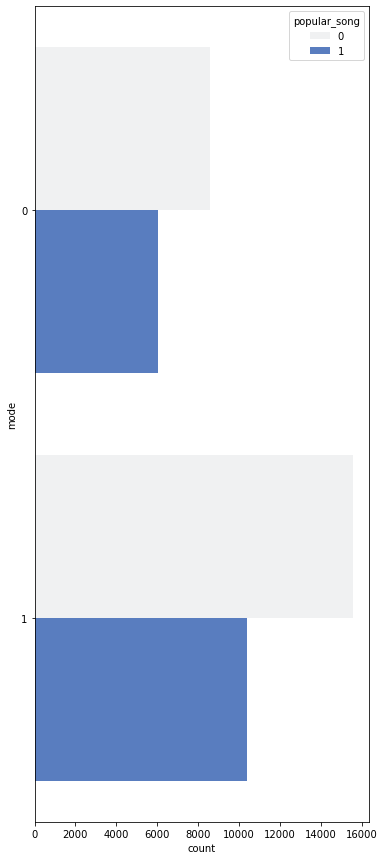

In [45]:
fig, ax = plt.subplots(figsize=(6,15))
# sns.set_color_codes('pastel')
sns.set_color_codes("muted")
ax = sns.countplot(y='mode', hue='popular_song', data=df.sort_values('popular_song', ascending=False), color='b')

In [47]:
# finally dropping all unnecessary columns
df.drop(columns = ['obtained_date', 'instance_id', 'popularity', 'artist_name','track_name', 'mode'], inplace = True)
df_af = df.copy()

### Distribution of Audio Features

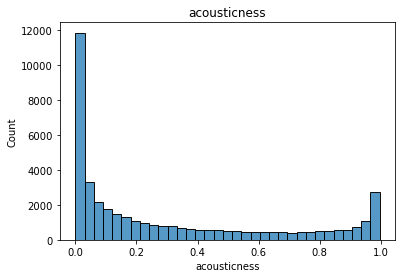

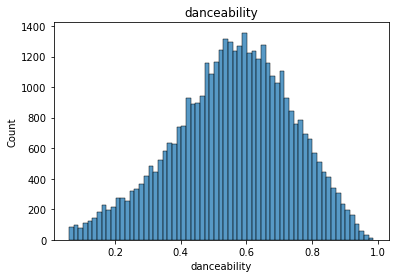

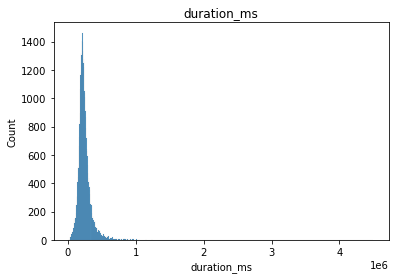

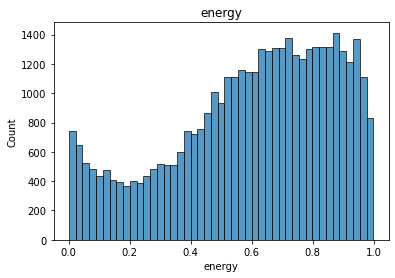

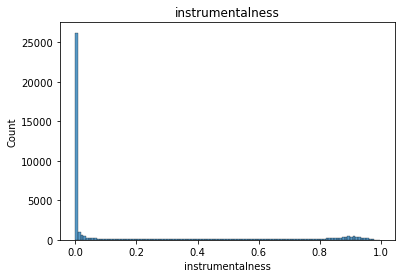

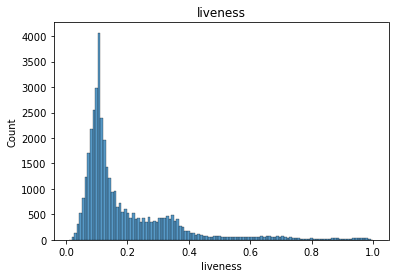

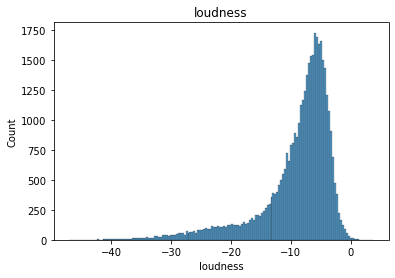

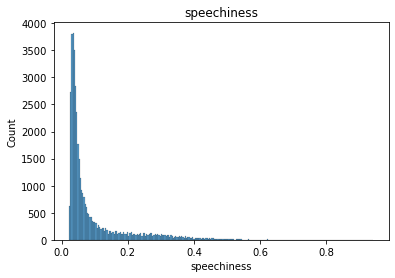

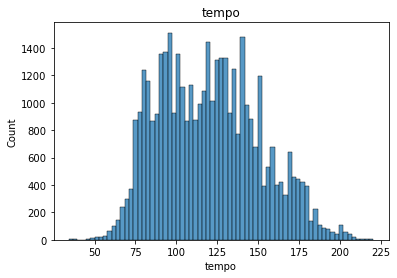

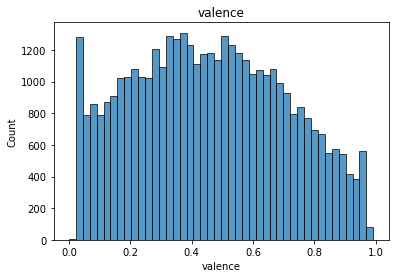

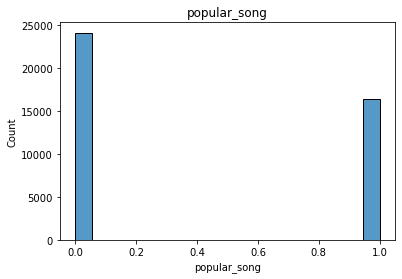

In [48]:
# Check for the distribution of each audio feature
numeric_feats = df.select_dtypes(exclude = 'object')

for x in numeric_feats.columns:
    sns.histplot(x=x, data=df_af)
    plt.title(x)
    plt.show()

### Checking for Outliers

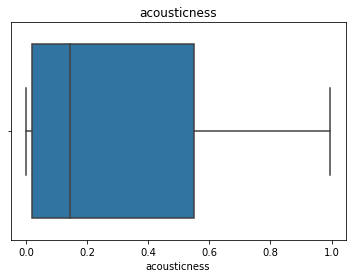

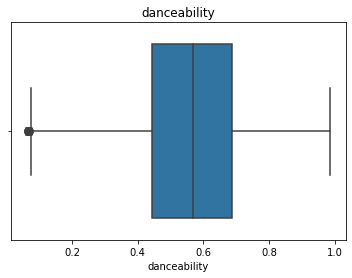

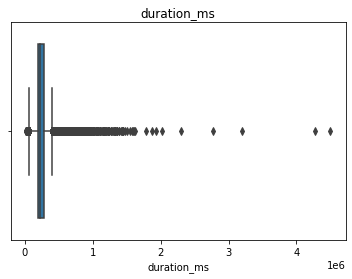

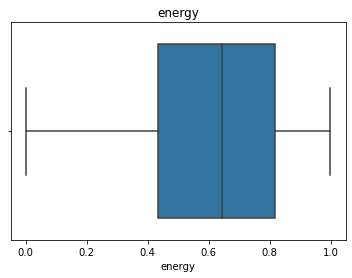

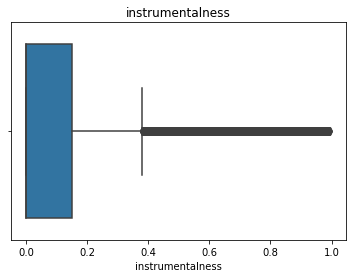

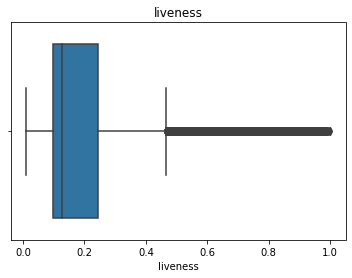

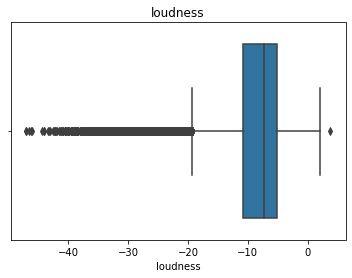

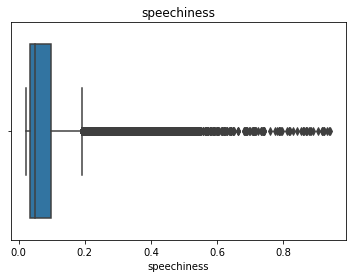

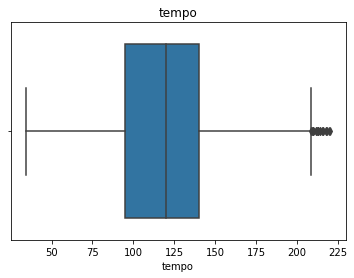

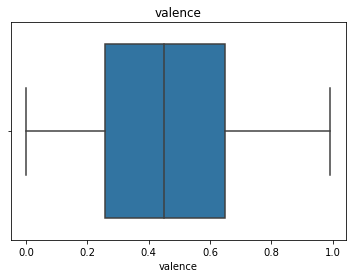

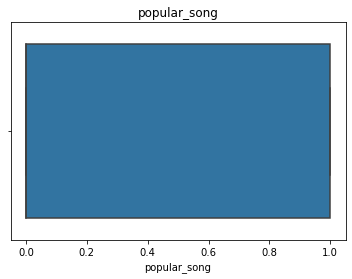

In [49]:
for x in numeric_feats.columns:
    sns.boxplot(x=x, data=df_af)
    plt.title(x)
    plt.show()

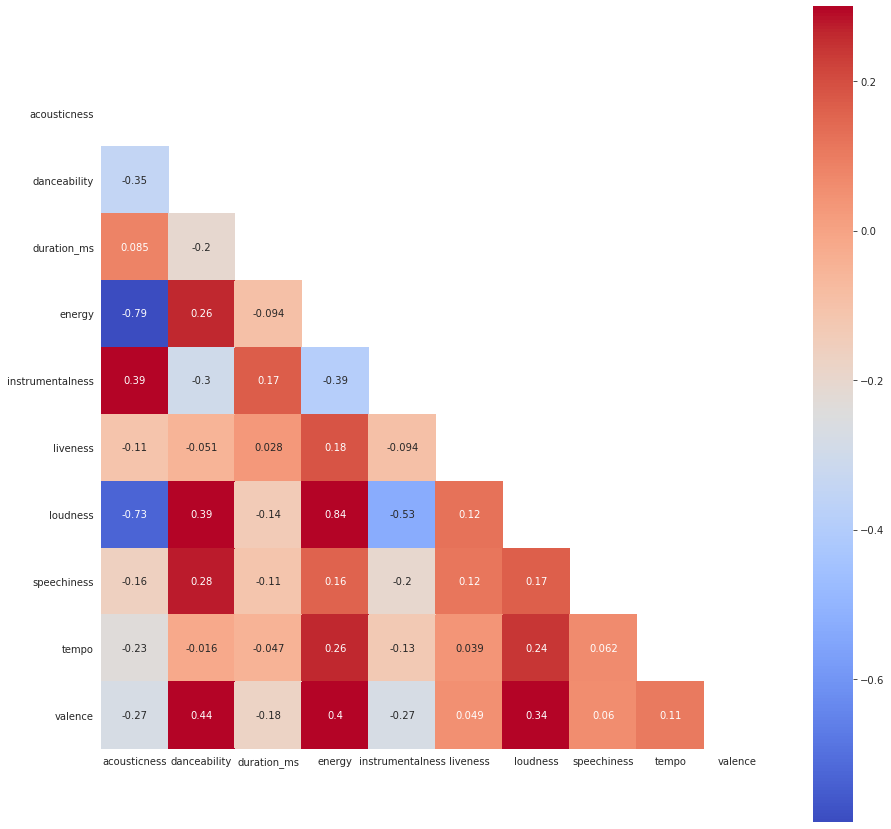

In [50]:
# Looking at the correlation among the audio features

TARGET = 'popular_song'
FEATURES = [x_col for x_col in df_af.columns if x_col != TARGET]

corr = df_af[FEATURES].corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(15, 15))
    ax = sns.heatmap(corr, mask=mask, vmax=.3, square=True, cmap='coolwarm', annot=True)

In [51]:
df_af.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40560 entries, 1 to 50004
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   acousticness      40560 non-null  float64
 1   danceability      40560 non-null  float64
 2   duration_ms       40560 non-null  int64  
 3   energy            40560 non-null  float64
 4   instrumentalness  40560 non-null  float64
 5   key               40560 non-null  object 
 6   liveness          40560 non-null  float64
 7   loudness          40560 non-null  float64
 8   speechiness       40560 non-null  float64
 9   tempo             40560 non-null  float64
 10  valence           40560 non-null  float64
 11  music_genre       40560 non-null  object 
 12  popular_song      40560 non-null  int64  
dtypes: float64(9), int64(2), object(2)
memory usage: 5.6+ MB


### Model Prepping
- Train test split the data

In [52]:
# Split the data into popular song and audio features
y = df['popular_song']
X = df.drop(columns=['popular_song'], axis=1)

In [53]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

# Create X_train and X_test variable for categorical & numerical column
train_cat = X_train.select_dtypes('object').columns
train_num = X_train.select_dtypes('number').columns

# OneHotEncode genres & keys
ohe = OneHotEncoder(sparse=False)
X_train_ohe = ohe.fit_transform(X_train[train_cat])
X_test_ohe = ohe.transform(X_test[train_cat])

# Create into a dataframe
X_train_ohe = pd.DataFrame(X_train_ohe, columns = ohe.get_feature_names(train_cat))
X_test_ohe = pd.DataFrame(X_test_ohe, columns = ohe.get_feature_names(train_cat))

# Combine
X_train_processed = pd.concat([X_train[train_num], X_train_ohe], axis=1)
X_test_processed = pd.concat([X_test[train_num], X_test_ohe], axis=1)



In [54]:
# looking at our train test split data
X_train_processed

,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,...,music_genre_Alternative,music_genre_Anime,music_genre_Blues,music_genre_Classical,music_genre_Country,music_genre_Electronic,music_genre_Hip-Hop,music_genre_Jazz,music_genre_Rap,music_genre_Rock
0,0.012400,0.585,154105,0.6500,0.000000,0.1120,-6.316,0.0657,189.923,0.7330,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.054100,0.703,203800,0.5850,0.000000,0.1290,-7.602,0.0443,93.067,0.5620,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.117000,0.480,224307,0.8750,0.000000,0.2340,-3.867,0.1490,147.914,0.3350,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.918000,0.143,635387,0.0618,0.908000,0.1360,-21.566,0.0412,90.317,0.0332,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.015900,0.682,313600,0.9510,0.000993,0.6310,0.118,0.2500,150.064,0.5480,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30415,0.655000,0.785,157038,0.5630,0.009160,0.1080,-7.805,0.1030,86.025,0.4250,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
30416,0.000126,0.626,188600,0.7910,0.021900,0.4390,-2.734,0.0721,133.204,0.4330,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
30417,0.142000,0.347,265981,0.9190,0.005420,0.7140,-7.390,0.1390,133.860,0.1300,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
30418,0.020000,0.378,250627,0.6380,0.000077,0.0849,-5.576,0.0750,184.086,0.7350,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


# Model


### Model Functions

In [55]:
def get_model(model):
    
    #Fit model
    model.fit(X_train_processed, y_train)
    
    # Get predictions
    y_pred_train = model.predict(X_train_processed)
    y_pred_test = model.predict(X_test_processed)
    
    # Get classification report
    target_names =  ['not popular', 'popular']
    print('              Classification Report for Training Set')
    print(classification_report(y_train, y_pred_train, target_names = target_names))
    print('              Classification Report for Test Set')
    print(classification_report(y_test, y_pred_test, target_names = target_names))
    
    # Plot confusion Matrix
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize = (10,6))
    plot_confusion_matrix(model, X_train_processed, y_train,
                     cmap=plt.cm.Blues, ax=ax0, 
                      display_labels = target_names, normalize = 'all')
    plot_confusion_matrix(model, X_test_processed, y_test,
                     cmap=plt.cm.Blues, ax=ax1,
                     display_labels = target_names, normalize = 'all')

    ax0.set(title = 'Train Confusion Matrix')
    ax1.set(title = 'Test Confusion Matrix')
    ax0.grid(False)
    ax1.grid(False)
    plt.show()
    
    return model

In [56]:
def tuned_metrics(model):
    
    # Get predictions
    y_pred_train = model.predict(X_train_processed)
    y_pred_test = model.predict(X_test_processed)
    
    # Get classification report
    target_names =  ['not popular', 'popular']
    print(f'              Classification Report for Training Set')
    print(classification_report(y_train, y_pred_train, target_names = target_names))
    print(f'              Classification Report for Test Set ')
    print(classification_report(y_test, y_pred_test, target_names = target_names))
    
    # Plot confusion Matrix
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize = (10,6))
    plot_confusion_matrix(model, X_train_processed, y_train,
                     cmap=plt.cm.Blues, ax=ax0, 
                      display_labels = target_names, normalize = 'all')
    plot_confusion_matrix(model, X_test_processed, y_test,
                     cmap=plt.cm.Blues, ax=ax1,
                     display_labels = target_names, normalize = 'all')

    ax0.set(title = f'Train Confusion Matrix')
    ax1.set(title = f'Test Confusion Matrix')
    ax0.grid(False)
    ax1.grid(False)
    plt.show()
    
    return model

## Logistics Regression Model
Fit the baseline model to the training set. 

              Classification Report for Training Set
              precision    recall  f1-score   support

 not popular       0.60      0.85      0.71     18190
     popular       0.44      0.17      0.24     12230

    accuracy                           0.58     30420
   macro avg       0.52      0.51      0.48     30420
weighted avg       0.54      0.58      0.52     30420

              Classification Report for Test Set
              precision    recall  f1-score   support

 not popular       0.59      0.85      0.70      5956
     popular       0.44      0.17      0.24      4184

    accuracy                           0.57     10140
   macro avg       0.51      0.51      0.47     10140
weighted avg       0.53      0.57      0.51     10140



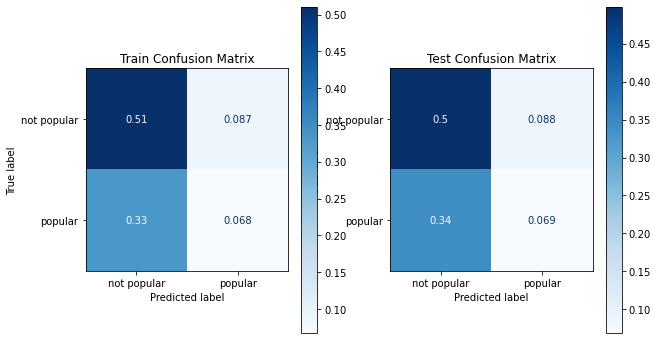

LogisticRegression()

In [57]:
logreg = LogisticRegression()
get_model(logreg)

**Accuracy**: Accuracy shows how many of our overall **True Positive and True Negative predictions** were correct. Whether it is a positive or negative prediction. True Positive + False Positive / Total of Observations (TN+FP+TP+FN)

**Precision**: Out of all the **predictions** how many were right? What percentage of your **predictions** were corect? True Positive / True Positive + False Positive

**Recall**: Out of all the **true positives** how many were right? What percentage of your **True Positives** were correct? True Positive / True Positive + False Negative

**F1-Score**: This metric takes into account precision and recall. What percentage of positive predictions were correct?

### Confusion Matrix

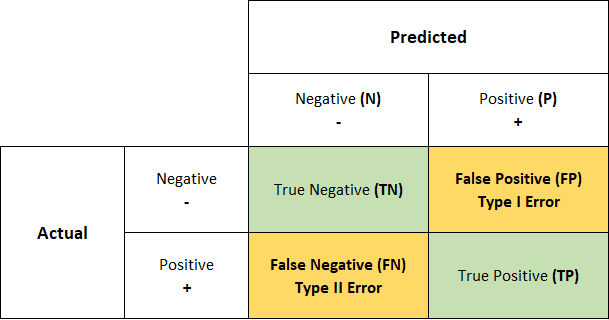

Based on our classification report and confusion matrix, our model seems to predicting the non-popular songs better than popular song. This could be the cause of slight class imbalance since since our confusion matrix seems to favor the non-popular classification.

In [58]:
# checking for class imbalance for target
y_train.value_counts(normalize = True)

0    0.597962
1    0.402038
Name: popular_song, dtype: float64

In [59]:
# explain results

## Decision Tree

### Decision Tree #1 Vanilla Classifier
Using the default setting without tweaking or tuning the data

              Classification Report for Training Set
              precision    recall  f1-score   support

 not popular       1.00      1.00      1.00     18190
     popular       1.00      1.00      1.00     12230

    accuracy                           1.00     30420
   macro avg       1.00      1.00      1.00     30420
weighted avg       1.00      1.00      1.00     30420

              Classification Report for Test Set
              precision    recall  f1-score   support

 not popular       0.83      0.82      0.82      5956
     popular       0.75      0.75      0.75      4184

    accuracy                           0.79     10140
   macro avg       0.79      0.79      0.79     10140
weighted avg       0.79      0.79      0.79     10140



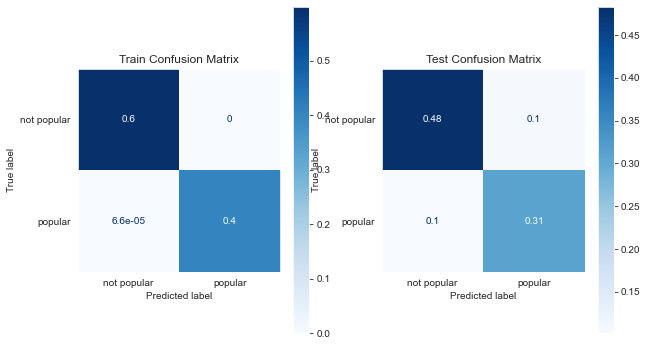

DecisionTreeClassifier()

In [63]:
dtc = DecisionTreeClassifier()
get_model(dtc)

100% on the training data and a lower test score shows a sign of overfitting. Meaning there is a godo performance on the training data but a poor generalization of the the other data.

In [64]:
# check AUC of predictions
get_auc(dtc)

0.7878777542642218

### Hyperparameter Tuning Decision Tree using Grid Search

In [66]:
# Set parameters
params = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [10, 50, 100, 150],
    'min_samples_leaf' : [.25, .50, 1,],
    'max_features' : ['sqrt', 'log2', None]
}

In [67]:
num_decision_trees = 2 * 4 * 3 * 3
print(f"Grid Search will have to search through {num_decision_trees} different permutations.")

Grid Search will have to search through 72 different permutations.


In [68]:
# Get parameters
grid = GridSearchCV(dtc, param_grid=params, cv=3)

In [69]:
grid.fit(X_train_processed, y_train)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [10, 50, 100, 150],
                         'max_features': ['sqrt', 'log2', None],
                         'min_samples_leaf': [0.25, 0.5, 1]})

In [70]:
# Find best estimator
grid.best_estimator_

DecisionTreeClassifier(criterion='entropy', max_depth=10)

In [71]:
# Find best parameters
best_parameters = grid.best_params_
best_parameters

{'criterion': 'entropy',
 'max_depth': 10,
 'max_features': None,
 'min_samples_leaf': 1}

### Decision Tree with Tuned Parameters

              Classification Report for Training Set
              precision    recall  f1-score   support

 not popular       0.87      0.92      0.89     18190
     popular       0.88      0.79      0.83     12230

    accuracy                           0.87     30420
   macro avg       0.87      0.86      0.86     30420
weighted avg       0.87      0.87      0.87     30420

              Classification Report for Test Set 
              precision    recall  f1-score   support

 not popular       0.85      0.91      0.88      5956
     popular       0.86      0.77      0.82      4184

    accuracy                           0.86     10140
   macro avg       0.86      0.84      0.85     10140
weighted avg       0.86      0.86      0.86     10140



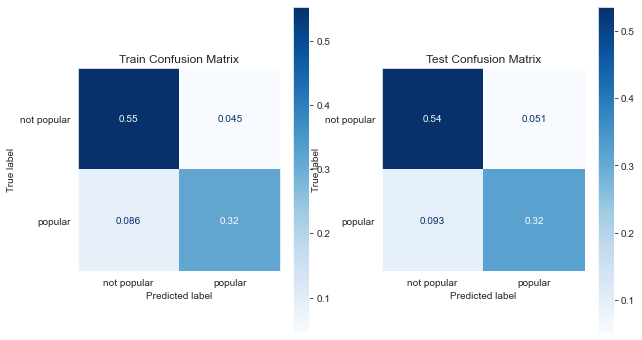

DecisionTreeClassifier(criterion='entropy', max_depth=10)

In [106]:
dtuned1 = grid.best_estimator_
tuned_metrics(grid.best_estimator_)

In [105]:
# check AUC of predictions
get_auc(dtuned1)

0.8443624822952769

The AUC score improves by 6%. Meaning the our tuned decision tree is able to predict the popular songs better than our vanilla decision tree.

## Random Forest Classifier
We're choosing entropy to reduce uncertainty as much as possible.

              Classification Report for Training Set
              precision    recall  f1-score   support

 not popular       0.83      0.97      0.89     18190
     popular       0.94      0.70      0.80     12230

    accuracy                           0.86     30420
   macro avg       0.88      0.83      0.85     30420
weighted avg       0.87      0.86      0.85     30420

              Classification Report for Test Set
              precision    recall  f1-score   support

 not popular       0.82      0.97      0.89      5956
     popular       0.94      0.70      0.80      4184

    accuracy                           0.86     10140
   macro avg       0.88      0.84      0.85     10140
weighted avg       0.87      0.86      0.85     10140



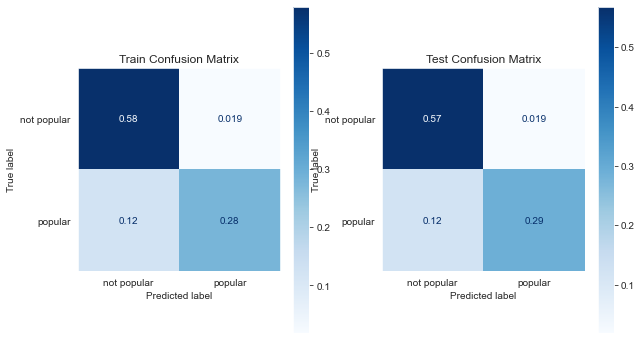

RandomForestClassifier(criterion='entropy', max_depth=5)

In [79]:
rfc = RandomForestClassifier(criterion='entropy', max_depth = 5)
get_model(rfc)

In [98]:
# check AUC of predictions
get_auc(rfc)

0.8357209562284028

### Hyperparameter Tuning Random Forest Classifier

In [80]:
# Set parameters
params = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [10, 50, 100, 150],
    'min_samples_leaf' : [.25, .50, 1,],
    'max_features' : ['sqrt', 'log2', None]
}

In [81]:
num_random_forest = 2 * 4 * 3 * 3
print(f"Grid Search will have to search through {num_decision_trees} different permutations.")

Grid Search will have to search through 72 different permutations.


In [82]:
rtc_grid = RandomForestClassifier(random_state=51)
rf_tuned_grid = GridSearchCV(rtc_grid, param_grid = params, cv=3)

In [83]:
rf_tuned_grid.fit(X_train_processed, y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=51),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [10, 50, 100, 150],
                         'max_features': ['sqrt', 'log2', None],
                         'min_samples_leaf': [0.25, 0.5, 1]})

In [84]:
# Find the best parameters
rf_tuned_grid.best_params_

{'criterion': 'entropy',
 'max_depth': 10,
 'max_features': 'sqrt',
 'min_samples_leaf': 1}

In [85]:
# Find best estimator
rf_tuned_grid.best_estimator_

RandomForestClassifier(criterion='entropy', max_depth=10, max_features='sqrt',
                       random_state=51)

              Classification Report for Training Set
              precision    recall  f1-score   support

 not popular       0.83      0.97      0.89     18190
     popular       0.93      0.71      0.80     12230

    accuracy                           0.86     30420
   macro avg       0.88      0.84      0.85     30420
weighted avg       0.87      0.86      0.86     30420

              Classification Report for Test Set 
              precision    recall  f1-score   support

 not popular       0.83      0.96      0.89      5956
     popular       0.93      0.71      0.81      4184

    accuracy                           0.86     10140
   macro avg       0.88      0.84      0.85     10140
weighted avg       0.87      0.86      0.86     10140



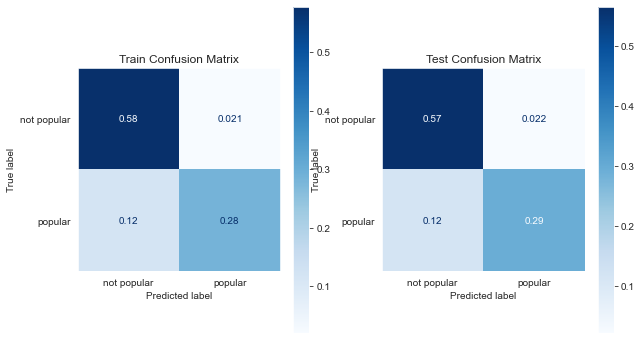

RandomForestClassifier(criterion='entropy', max_depth=10, max_features='sqrt',
                       random_state=51)

In [107]:
rf_tuned = rf_tuned_grid.best_estimator_
tuned_metrics(rf_tuned_grid.best_estimator_)

In [108]:
# check AUC of predictions
get_auc(rf_tuned)

0.83723003106272

## XGBoost

              Classification Report for Training Set
              precision    recall  f1-score   support

 not popular       0.84      0.96      0.89     18190
     popular       0.92      0.73      0.81     12230

    accuracy                           0.86     30420
   macro avg       0.88      0.84      0.85     30420
weighted avg       0.87      0.86      0.86     30420

              Classification Report for Test Set
              precision    recall  f1-score   support

 not popular       0.83      0.95      0.89      5956
     popular       0.91      0.73      0.81      4184

    accuracy                           0.86     10140
   macro avg       0.87      0.84      0.85     10140
weighted avg       0.87      0.86      0.86     10140



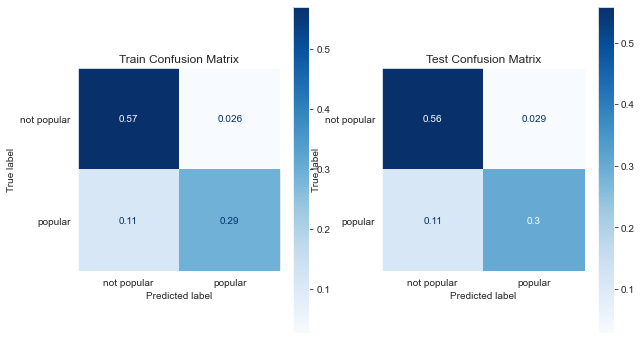

GradientBoostingClassifier(random_state=42)

In [95]:
# Instantiate an GradientBoostingClassifier
xgb_clf = GradientBoostingClassifier(random_state=42)
get_model(xgb_clf)

In [97]:
# check AUC of predictions
get_auc(xgb_clf)

0.8409138333759232

## Feature Importance

In [110]:
def plot_feature_importances(model, data, title):
    with plt.style.context(['fivethirtyeight', 'seaborn-poster']):
    # Sorting and coloring.
        formatted_data = list(
            zip(model.feature_importances_, 
                [x.title() for x in data.columns])
        )
        formatted_data.sort(key=lambda x: x[0])
        colors=['#7f7f7f' if x[0]<=0.1 else '#1f77b4' for x in formatted_data]
    
        # Plotting.
        fig, ax = plt.subplots(figsize=(8,8))
        ax.barh(
            width=[d[0] for d in formatted_data], 
            y=[d[1] for d in formatted_data],
            color=colors)
        ax.set(title=f'{title}: Feature Importance')
    
    return model

### Decision Tree

DecisionTreeClassifier()

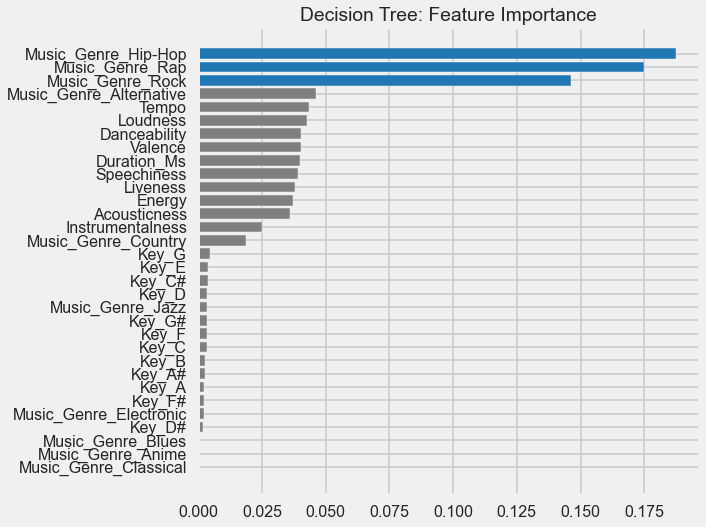

In [115]:
plot_feature_importances(dtc, X_train_processed, 'Decision Tree')

### Tuned Decision Tree

DecisionTreeClassifier(criterion='entropy', max_depth=10)

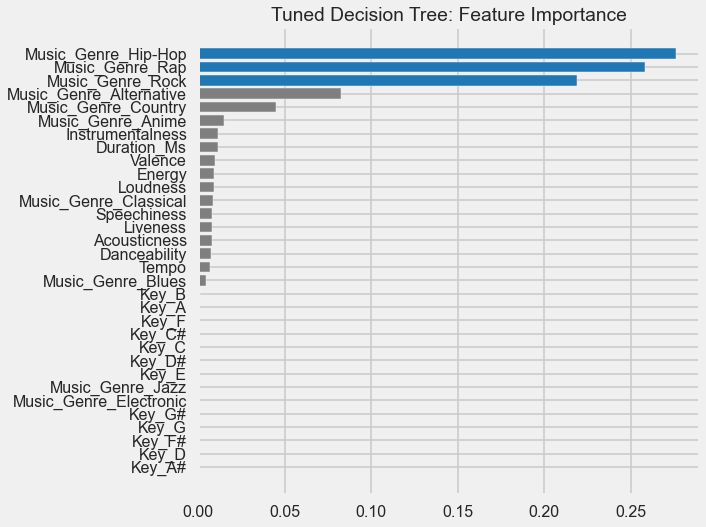

In [134]:
plot_feature_importances(dtuned1, X_train_processed, 'Tuned Decision Tree')

### Random Forest

RandomForestClassifier(criterion='entropy', max_depth=5)

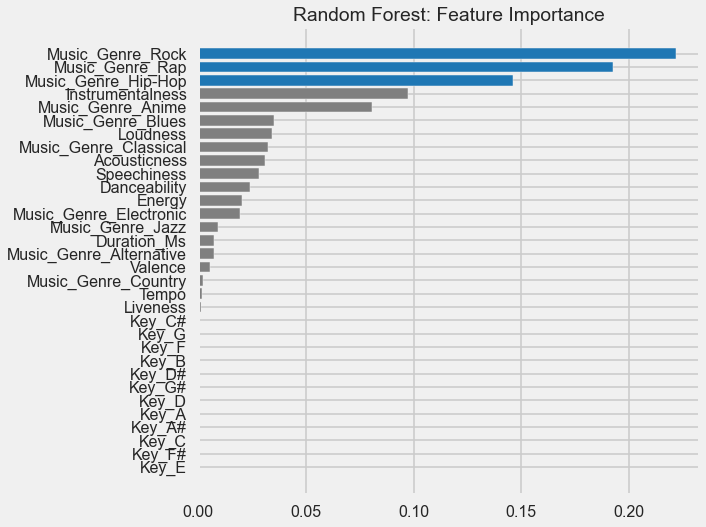

In [121]:
plot_feature_importances(rfc, X_train_processed, 'Random Forest')

### Random Forest Tuned

RandomForestClassifier(criterion='entropy', max_depth=10, max_features='sqrt',
                       random_state=51)

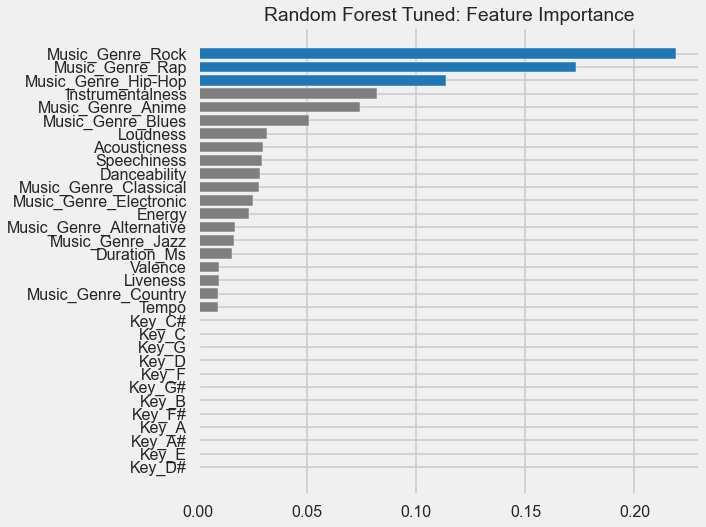

In [122]:
plot_feature_importances(rf_tuned, X_train_processed, 'Random Forest Tuned')

### XGBoost

GradientBoostingClassifier(random_state=42)

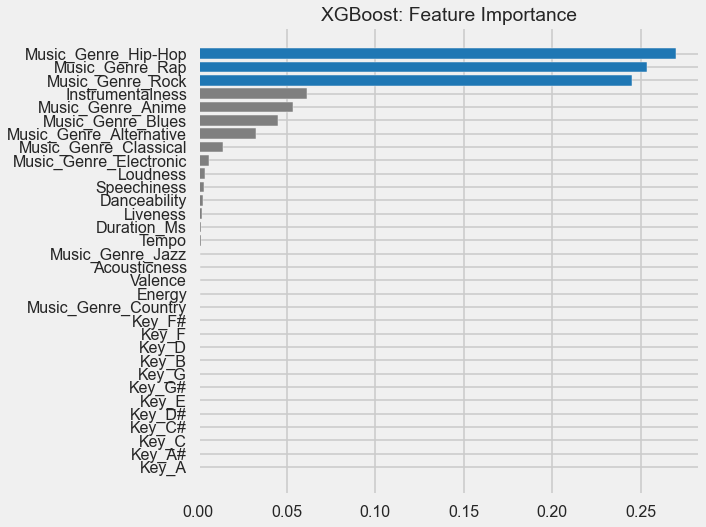

In [123]:
plot_feature_importances(xgb_clf, X_train_processed, 'XGBoost')

### ROC & AUC Model Performance

The **Receiver Operating Characteristic (ROC)** is known for giving us a visual of the trade off between the **false positive** and **true positive rates**. While the Area Under Curve is the metric to compare the classes which is the summary to compare the ROC curve. 

AUC = 1 means that the classifier is able to perfectly distinguish all the Positive and Negative class points correctly. So our goal is the achieve a AUC closest to 1.

In [126]:
def get_roc(model):
    # Calculate the probability scores of each point in the training set
    y_train_score = model.decision_function(X_train_processed)

    # Calculate the fpr, tpr, and thresholds for the training set
    train_fpr, train_tpr, thresholds = roc_curve(y_train, y_train_score)

    # Calculate the probability scores of each point in the test set
    y_test_score = model.decision_function(X_test_processed)

    # Calculate the fpr, tpr, and thresholds for the test set
    test_fpr, test_tpr, test_thresholds = roc_curve(y_test, y_test_score)
    
    # plotting ROC curve
    plt.subplots(figsize = (10,6))

    sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

    # training set
    lw = 2
    plt.plot(train_fpr, train_tpr, color='darkorange',
             lw=lw, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve for Training Set')
    plt.legend(loc='lower right')
    print('Training AUC: {}'.format(auc(train_fpr, train_tpr)))
    plt.show()
    
    # ROC curve for test set
    plt.figure(figsize=(10, 8))
    lw = 2
    plt.plot(test_fpr, test_tpr, color='darkorange',
             lw=lw, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve for Test Set')
    plt.legend(loc='lower right')
    print('Test AUC: {}'.format(auc(test_fpr, test_tpr)))
    print('')
    plt.show()


In [127]:
def get_auc(model):
    y_pred = model.predict(X_test_processed)

    # Check the AUC of predictions
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    roc_auc
    return roc_auc

### Logistic Regression

Training AUC: 0.6315859126679993


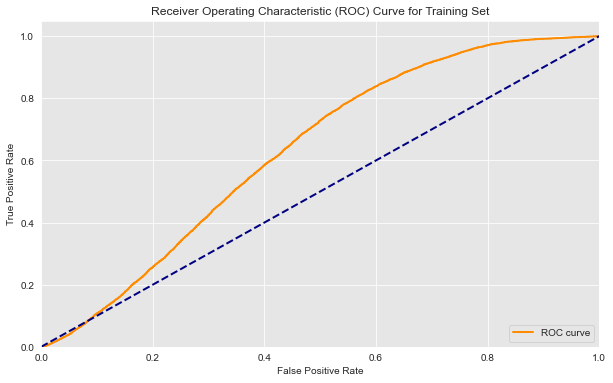

Test AUC: 0.628626619107361



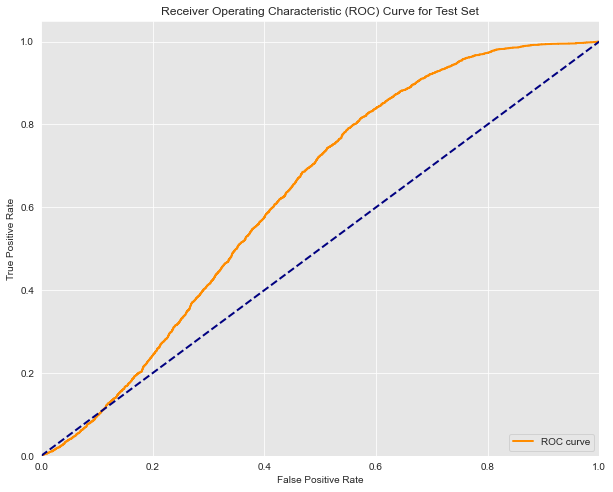

In [128]:
get_roc(logreg)

In [129]:
print(f' The AUC score for our Decision Tree Model is {get_auc(dtc)}')
print(f' The AUC score for our Tuned Decision Tree Model is {get_auc(dtuned1)}')
print(f' The AUC score for our Random Forest Tree Model is {get_auc(rfc)}')
print(f' The AUC score for our Tuned Random Forest Tree Model is {get_auc(rf_tuned)}')
print(f' The AUC score for our XGBoost Model is {get_auc(xgb_clf)}')

 The AUC score for our Decision Tree Model is 0.7878777542642218
 The AUC score for our Tuned Decision Tree Model is 0.8443624822952769
 The AUC score for our Random Forest Tree Model is 0.8357209562284028
 The AUC score for our Tuned Random Forest Tree Model is 0.83723003106272
 The AUC score for our XGBoost Model is 0.8409138333759232


# Conclusion

Out of all the models that were trained, the final model that performed the best is our **Tuned Decision Tree Classifier**.  As we optimized the Decision tree the test accuracy score improved by 7 points. For AUC, the Decision Tree Classifier after optimizing the percentage increases by ~7% on detecting how well it was able to predict the popular songs from the false positive popular songs.

The reason we choose our Tuned Decision Tree's accuracy score of .87 as our metric because we want to know how well the model predicted the popular (true positive) and not popular (true negative) tracks overall. As for our Area Under the Curve it proved to have the highest percentage out of all the models.

**Reccomendations:**

Based on the Decision Tree's feature importance, record labels should focus on artists who specialize in genres like **Rock, Hip-Hop and Rap**  while prioritizing audio features such as **instrumentals, track duration, valence and loudness**. On the other hand, the key signature and the genre Jazz and EDM music does not play into a huge factor on a song's popularity. 

# Future Work

- Iterate the missing feature information and scaping more audio features from Spotify's API to see if other audio features changes our predictions
- Scape data from other platforms such as BillBoard, SoundCloud, Apple Music and use classification models to compare their popular audio features
- Look into various Rock, Hip-Hop, and Rap artists to see who is the most popular based on scapring data from Spotify's API based on their popularity or follow count